# 🚀 Complete LangGraph Tutorial: From Basics to Advanced Applications

## 📖 Comprehensive Guide for Building Stateful AI Agents

Welcome to the most comprehensive LangGraph tutorial! This notebook will take you from complete beginner to building sophisticated AI agents step by step.

### 🎯 What You'll Learn

By the end of this tutorial, you will:
- ✅ Understand LangGraph's core concepts (Nodes, Edges, State)
- ✅ Build your first simple chatbot
- ✅ Add memory and persistence to conversations
- ✅ Implement tool calling and external integrations
- ✅ Create human-in-the-loop workflows
- ✅ Build multi-agent systems
- ✅ Handle complex state management
- ✅ Deploy production-ready applications

### 📚 Based on Official LangGraph Documentation

This tutorial follows the [official LangGraph documentation](https://langchain-ai.github.io/langgraph/) and incorporates best practices from the LangGraph team.

---

## 📋 Table of Contents

1. **[Setup & Installation](#setup)**
2. **[Part 1: Understanding LangGraph Fundamentals](#part1)**
3. **[Part 2: Building Your First Simple Agent](#part2)**
4. **[Part 3: Adding Memory with Checkpointing](#part3)**
5. **[Part 4: Tool Integration & External APIs](#part4)**
6. **[Part 5: Human-in-the-Loop Workflows](#part5)**
7. **[Part 6: Advanced State Management](#part6)**
8. **[Part 7: Multi-Agent Systems](#part7)**
9. **[Part 8: Real-World Use Cases](#part8)**
10. **[Part 9: Production Deployment](#part9)**

Let's begin this exciting journey! 🌟


## 🔧 Setup & Installation {#setup}

Before we dive into LangGraph, let's set up our environment properly.

### Prerequisites

1. **Python 3.8+** installed on your system
2. **API Keys** for LLM providers (we'll use OpenAI in this tutorial)
3. **Basic Python knowledge** - understanding of functions, classes, and dictionaries

### What is LangGraph?

**LangGraph** is a library for building **stateful, multi-actor applications** with LLMs. It extends LangChain with the ability to coordinate multiple chains (or actors) across multiple steps of computation in a **cyclic** manner.

Key features:
- 🔄 **Cyclic workflows** (not just linear chains)
- 💾 **Persistent state** across interactions
- 🎯 **Conditional routing** between different paths
- 🔧 **Human-in-the-loop** capabilities
- 📊 **Built-in observability** with LangSmith

Think of it as a way to build AI agents that can:
- Remember previous conversations
- Make decisions about what to do next
- Use tools and external APIs
- Involve humans when needed
- Handle complex, multi-step workflows


In [1]:
# Install required packages
!pip install -q langgraph langsmith langchain-openai python-dotenv

# Optional: for visualization
!pip install -q matplotlib graphviz


In [2]:
import os
import getpass
from typing import Annotated, Dict, List, Any
from typing_extensions import TypedDict

# Set up environment variables
def setup_environment():
    """Setup API keys for the tutorial"""
    
    # OpenAI API Key
    if not os.environ.get("OPENAI_API_KEY"):
        openai_key = getpass.getpass("Enter your OpenAI API Key: ")
        os.environ["OPENAI_API_KEY"] = openai_key
    
    # Optional: LangSmith for observability (highly recommended)
    if not os.environ.get("LANGSMITH_API_KEY"):
        print("LangSmith setup (optional but recommended for debugging):")
        langsmith_key = getpass.getpass("Enter your LangSmith API Key (or press Enter to skip): ")
        if langsmith_key:
            os.environ["LANGSMITH_API_KEY"] = langsmith_key
            os.environ["LANGCHAIN_TRACING_V2"] = "true"
            os.environ["LANGCHAIN_PROJECT"] = "LangGraph-Tutorial"
            print("✅ LangSmith tracing enabled!")
        else:
            print("⚠️ Skipping LangSmith setup")
    
    print("🚀 Environment setup complete!")

# Run setup
setup_environment()


🚀 Environment setup complete!


## 🧠 Part 1: Understanding LangGraph Fundamentals {#part1}

Before we build anything, let's understand the core concepts that make LangGraph powerful.

### 🔑 Core Concepts

#### 1. **State** 
- The "memory" of your application
- Shared data structure that persists across all steps
- Can contain messages, variables, flags, or any data you need

#### 2. **Nodes**
- Individual functions or operations in your workflow
- Each node receives the current state and returns updates
- Think of them as "workers" that do specific tasks

#### 3. **Edges** 
- Connections between nodes that define the flow
- Can be simple (A → B) or conditional (A → B or C based on logic)

#### 4. **Graph**
- The complete workflow combining nodes and edges
- Defines how your AI agent behaves and makes decisions

### 🎯 Simple Mental Model

Think of LangGraph like a **flowchart for AI agents**:

```
[User Input] → [AI Thinks] → [Uses Tool?] 
                    ↓              ↓
               [Respond]      [Call Tool] → [AI Thinks] → [Respond]
```

But unlike a simple flowchart, LangGraph can:
- Remember everything that happened before
- Loop back to previous steps
- Involve humans in the decision-making
- Handle complex, branching logic

Let's see this in action! 👇


## 🤖 Part 2: Building Your First Simple Agent {#part2}

Let's start with the simplest possible LangGraph application - a basic chatbot that can have a conversation.

### Step 1: Define the State

The state is like the "memory" of our agent. For a chatbot, we need to remember the conversation history.


In [3]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage

# Define our State - this is the "memory" of our agent
class State(TypedDict):
    # messages will store our conversation history
    # add_messages is a special function that appends new messages instead of replacing them
    messages: Annotated[list, add_messages]

print("✅ State defined!")
print("Our state has one field: 'messages' that will store the conversation history")
print("The add_messages function ensures new messages are appended, not replaced")


✅ State defined!
Our state has one field: 'messages' that will store the conversation history
The add_messages function ensures new messages are appended, not replaced


### Step 2: Create the Language Model

Now we need an AI model to power our chatbot. We'll use OpenAI's GPT model.


In [ ]:
from langchain_openai import ChatOpenAI

# Initialize the language model
llm = ChatOpenAI(
    model="gpt-4o",  # You can also use "gpt-4" if you have access
    temperature=0.7,        # Controls creativity (0 = deterministic, 1 = very creative)
)

print("✅ Language model initialized!")
print(f"Model: {llm.model_name}")

# Let's test it quickly
test_response = llm.invoke("Say hello in a friendly way!")
print(f"Test response: {test_response.content}")


✅ Language model initialized!
Model: gpt-3.5-turbo
Test response: Hello there! How are you doing today?


### Step 3: Create the Chatbot Node

A **node** is a function that:
1. Takes the current state as input
2. Does some work (like calling the LLM)
3. Returns updates to the state

Let's create our chatbot node:


In [5]:
def chatbot_node(state: State) -> Dict[str, Any]:
    """
    The main chatbot node that processes messages and generates responses.
    
    Args:
        state: Current state containing conversation history
        
    Returns:
        Dict with new messages to add to state
    """
    # Get the conversation history from state
    messages = state["messages"]
    
    # Call the LLM with the conversation history
    response = llm.invoke(messages)
    
    # Return the new message to be added to state
    return {"messages": [response]}

print("✅ Chatbot node created!")
print("This node will:")
print("1. Take the conversation history from state")
print("2. Send it to the LLM")
print("3. Return the LLM's response to be added to state")


✅ Chatbot node created!
This node will:
1. Take the conversation history from state
2. Send it to the LLM
3. Return the LLM's response to be added to state


### Step 4: Build the Graph

Now we'll create the graph by:
1. Creating a StateGraph
2. Adding our chatbot node
3. Defining the flow (edges)
4. Compiling it into a runnable application


In [6]:
# Step 1: Create the graph builder
graph_builder = StateGraph(State)

# Step 2: Add our chatbot node
graph_builder.add_node("chatbot", chatbot_node)

# Step 3: Define the flow
# START -> chatbot -> END
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# Step 4: Compile the graph
simple_chatbot = graph_builder.compile()

print("✅ Simple chatbot graph created!")
print("Flow: START → chatbot → END")
print("Ready to chat! 🎉")


✅ Simple chatbot graph created!
Flow: START → chatbot → END
Ready to chat! 🎉


### Step 5: Test Your First LangGraph Agent!

Let's test our simple chatbot. We'll send it a message and see how it responds.


In [7]:
# Test our simple chatbot
def test_simple_chatbot():
    print("🤖 Testing Simple Chatbot")
    print("=" * 40)
    
    # Create initial state with a user message
    initial_state = {
        "messages": [HumanMessage(content="Hello! My name is Niyantarana Tagore. What's your name?")]
    }
    
    # Run the chatbot
    result = simple_chatbot.invoke(initial_state)
    
    # Print the conversation
    for i, message in enumerate(result["messages"]):
        if isinstance(message, HumanMessage):
            print(f"👤 Human: {message.content}")
        elif isinstance(message, AIMessage):
            print(f"🤖 AI: {message.content}")
    
    print("\n" + "=" * 40)
    return result

# Run the test
first_result = test_simple_chatbot()


🤖 Testing Simple Chatbot
👤 Human: Hello! My name is Niyantarana Tagore. What's your name?
🤖 AI: Hello Niyantarana Tagore! Nice to meet you. My name is Assistant. How can I assist you today?



In [8]:
def test_simple_chatbot(user_input):
    print("🤖 Testing Simple Chatbot")
    print("=" * 40)
    
    initial_state = {
        "messages": [HumanMessage(content=user_input)]
    }
    
    result = simple_chatbot.invoke(initial_state)
    
    for i, message in enumerate(result["messages"]):
        if isinstance(message, HumanMessage):
            print(f"👤 Human: {message.content}")
        elif isinstance(message, AIMessage):
            print(f"🤖 AI: {message.content}")
    
    print("\n" + "=" * 40)
    return result


In [9]:
test_simple_chatbot("What is the GATE cutoff for ECE?")

🤖 Testing Simple Chatbot
👤 Human: What is the GATE cutoff for ECE?
🤖 AI: The GATE cutoff for ECE (Electronics and Communication Engineering) varies every year depending on various factors such as the difficulty level of the exam, the number of applicants, and the number of available seats in different institutes. It is recommended to check the official GATE website or the website of the specific institute you are interested in for the most accurate and up-to-date information on GATE cutoff scores for ECE.



{'messages': [HumanMessage(content='What is the GATE cutoff for ECE?', additional_kwargs={}, response_metadata={}, id='bd6e74e9-f4c4-47f9-b3af-ec3804387e53'),
  AIMessage(content='The GATE cutoff for ECE (Electronics and Communication Engineering) varies every year depending on various factors such as the difficulty level of the exam, the number of applicants, and the number of available seats in different institutes. It is recommended to check the official GATE website or the website of the specific institute you are interested in for the most accurate and up-to-date information on GATE cutoff scores for ECE.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 84, 'prompt_tokens': 17, 'total_tokens': 101, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125',

In [10]:
test_simple_chatbot("What are the Subjects in GATE ECE?")

🤖 Testing Simple Chatbot
👤 Human: What are the Subjects in GATE ECE?
🤖 AI: The subjects in GATE ECE (Electronics and Communication Engineering) are as follows:

1. Engineering Mathematics
2. Networks, Signals, and Systems
3. Electronic Devices
4. Analog Circuits
5. Digital Circuits
6. Control Systems
7. Communications
8. Electromagnetics
9. General Aptitude



{'messages': [HumanMessage(content='What are the Subjects in GATE ECE?', additional_kwargs={}, response_metadata={}, id='4bde8332-c7c9-47d5-b1b0-db30d8d8ad2b'),
  AIMessage(content='The subjects in GATE ECE (Electronics and Communication Engineering) are as follows:\n\n1. Engineering Mathematics\n2. Networks, Signals, and Systems\n3. Electronic Devices\n4. Analog Circuits\n5. Digital Circuits\n6. Control Systems\n7. Communications\n8. Electromagnetics\n9. General Aptitude', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 70, 'prompt_tokens': 17, 'total_tokens': 87, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BnhsVkz4eyufRQCoLqYYUCVSNFTGp', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': N

### 🎉 Congratulations!

You just built your first LangGraph agent! But there's a problem...

**The Issue**: Our chatbot doesn't remember previous conversations. Each time we call it, it starts fresh.

Let's test this:


In [11]:
# Test memory issue - the chatbot won't remember the previous conversation
print("🧪 Testing Memory Issue")
print("=" * 40)

# Second message - asking about the name mentioned earlier
second_state = {
    "messages": [HumanMessage(content="What was my name again?")]
}

result2 = simple_chatbot.invoke(second_state)

for message in result2["messages"]:
    if isinstance(message, HumanMessage):
        print(f"👤 Human: {message.content}")
    elif isinstance(message, AIMessage):
        print(f"🤖 AI: {message.content}")

print("\n❌ As you can see, the chatbot doesn't remember your name!")
print("This is because each call starts with a fresh state.")
print("In the next section, we'll fix this with **memory and checkpointing**! 🧠")


🧪 Testing Memory Issue
👤 Human: What was my name again?
🤖 AI: I'm sorry, I don't have access to that information.

❌ As you can see, the chatbot doesn't remember your name!
This is because each call starts with a fresh state.
In the next section, we'll fix this with **memory and checkpointing**! 🧠


## 🧠 Part 3: Adding Memory with Checkpointing {#part3}

The power of LangGraph really shines when we add **persistent memory**. This allows our agent to:

- Remember conversations across multiple interactions
- Resume from where it left off
- Handle long-running workflows
- Support human-in-the-loop scenarios

### What is Checkpointing?

**Checkpointing** automatically saves the state after each step. When you invoke the graph again with the same `thread_id`, it loads the saved state and continues from there.

Think of it like a video game save system! 🎮

### Step 1: Set Up a Checkpointer


In [12]:
!pip install langgraph-checkpoint-sqlite

In [13]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()


print("✅ Checkpointer created!")
print("This will automatically save and restore conversation state")
print("In production, you'd use a real database file instead of ':memory:'")


✅ Checkpointer created!
This will automatically save and restore conversation state
In production, you'd use a real database file instead of ':memory:'


### Step 2: Create a Chatbot with Memory

Now let's rebuild our chatbot with memory capabilities:


In [14]:
graph_builder_with_memory = StateGraph(State)

graph_builder_with_memory.add_node("chatbot", chatbot_node)
graph_builder_with_memory.add_edge(START, "chatbot")
graph_builder_with_memory.add_edge("chatbot", END)

chatbot_with_memory = graph_builder_with_memory.compile(checkpointer=memory)

In [15]:
import uuid
unique_id = uuid.uuid4()
str(unique_id)
print(f"Unique ID for this conversation: {unique_id}")

Unique ID for this conversation: f53ef741-dd09-41b3-96b9-6b5997197d5f


In [18]:
unique_id = "f53ef741-dd09-41b3-96b9-6b5997197d5f"
def test_simple(user_input):
    
    config = {"configurable": {"thread_id":str(unique_id)}}
    result = chatbot_with_memory.invoke(
        {"messages": [HumanMessage(content=user_input)]},
        config
    )
    return result

### Step 3: Test the Memory

The key to using memory is the **config** parameter with a `thread_id`. All conversations with the same `thread_id` will share memory.


In [20]:
def test_memory_chatbot():
    print("🧠 Testing Chatbot with Memory")
    print("=" * 50)
    
    # Configuration with thread_id - this is crucial for memory!
    config = {"configurable": {"thread_id": "conversation_1"}}
    
    # First message
    print("📝 First interaction:")
    result1 = chatbot_with_memory.invoke(
        {"messages": [HumanMessage(content="Hi! My name is Niyantarana Tagore and I am an AI Agent Developer.")]},
        config  # Pass config as second parameter!
    )
    
    for message in result1["messages"]:
        if isinstance(message, HumanMessage):
            print(f"👤 Human: {message.content}")
        elif isinstance(message, AIMessage):
            print(f"🤖 AI: {message.content}")
    
    print("\n📝 Second interaction (same thread_id):")
    result2 = chatbot_with_memory.invoke(
        {"messages": [HumanMessage(content="What's my name and what I do?")]},
        config  # Same config = same memory!
    )
    
    # Only show the new messages
    new_messages = result2["messages"][len(result1["messages"]):]
    for message in new_messages:
        if isinstance(message, HumanMessage):
            print(f"👤 Human: {message.content}")
        elif isinstance(message, AIMessage):
            print(f"🤖 AI: {message.content}")
    
    print("\n✅ Success! The chatbot remembered both your name and Specialization!")
    return result2

# Test the memory
memory_result = test_memory_chatbot()


🧠 Testing Chatbot with Memory
📝 First interaction:
👤 Human: Hi! My name is Niyantarana Tagore and I am an AI Agent Developer.
👤 Human: Hi! My name is Niyantarana Tagore and I am an AI Agent Developer.
👤 Human: Hi! My name is Niyantarana Tagore and I am an AI Agent Developer.
🤖 AI: Hello, Niyantarana Tagore! It's great to meet another AI Agent Developer. What kind of projects are you currently working on in the AI field?

📝 Second interaction (same thread_id):
👤 Human: What's my name and what I do?
🤖 AI: Your name is Niyantarana Tagore, and you are an AI Agent Developer.

✅ Success! The chatbot remembered both your name and Specialization!


### 🔍 Understanding Thread IDs

Different `thread_id`s create separate conversations. Let's test this:


In [21]:
# Test with a different thread_id
print("🔄 Testing Different Thread ID")
print("=" * 40)

# Different thread_id = fresh conversation
different_config = {"configurable": {"thread_id": "conversation_2"}}

result_different = chatbot_with_memory.invoke(
    {"messages": [HumanMessage(content="What's my name?")]},
    different_config  # Different thread_id!
)

for message in result_different["messages"]:
    if isinstance(message, HumanMessage):
        print(f"👤 Human: {message.content}")
    elif isinstance(message, AIMessage):
        print(f"🤖 AI: {message.content}")

print("\n🎯 Key Insight:")
print("- Same thread_id = shared memory")
print("- Different thread_id = separate conversations")
print("- This allows multiple users or conversation contexts!")


🔄 Testing Different Thread ID
👤 Human: What's my name?
🤖 AI: I'm sorry, I do not know your name as I am an AI assistant and do not have access to personal information.

🎯 Key Insight:
- Same thread_id = shared memory
- Different thread_id = separate conversations
- This allows multiple users or conversation contexts!


### 📊 Inspecting the State

You can inspect the current state of any conversation using `get_state()`:


In [22]:
# Inspect the state of our first conversation
config1 = {"configurable": {"thread_id": "conversation_1"}}
state_snapshot = chatbot_with_memory.get_state(config1)

print("📊 State Inspection")
print("=" * 30)
print(f"Number of messages: {len(state_snapshot.values['messages'])}")
print(f"Next node to execute: {state_snapshot.next}")
print(f"Thread ID: {state_snapshot.config['configurable']['thread_id']}")

print("\n💬 Full conversation history:")
for i, message in enumerate(state_snapshot.values["messages"], 1):
    if isinstance(message, HumanMessage):
        print(f"{i}. 👤 Human: {message.content}")
    elif isinstance(message, AIMessage):
        print(f"{i}. 🤖 AI: {message.content[:100]}...")  # Truncate for readability


📊 State Inspection
Number of messages: 6
Next node to execute: ()
Thread ID: conversation_1

💬 Full conversation history:
1. 👤 Human: Hi! My name is Niyantarana Tagore and I am an AI Agent Developer.
2. 👤 Human: Hi! My name is Niyantarana Tagore and I am an AI Agent Developer.
3. 👤 Human: Hi! My name is Niyantarana Tagore and I am an AI Agent Developer.
4. 🤖 AI: Hello, Niyantarana Tagore! It's great to meet another AI Agent Developer. What kind of projects are ...
5. 👤 Human: What's my name and what I do?
6. 🤖 AI: Your name is Niyantarana Tagore, and you are an AI Agent Developer....


## 🛠️ Part 4: Tool Integration & External APIs {#part4}

Real AI agents need to interact with the outside world! Let's add tool calling capabilities to our chatbot.

### What are Tools?

Tools are functions that your AI agent can call to:
- Search the web
- Query databases
- Send emails
- Perform calculations
- Access APIs
- And much more!

### Step 1: Create a Simple Tool

Let's start with a simple calculator tool:


In [39]:
from langchain_core.tools import tool
from datetime import datetime
import math

@tool
def calculator(expression: str) -> str:
    """
    Safely evaluate a mathematical expression using allowed math functions.
    
    Args:
        expression (str): A mathematical expression to evaluate (e.g., "2 + 3 * 4")
        
    Returns:
        str: The result or an error message
    """
    try:
        # Define safe functions from math module
        safe_math = {name: obj for name, obj in math.__dict__.items() if not name.startswith("__")}
        # Include built-in functions that are safe
        safe_math.update({"abs": abs, "round": round})

        # Evaluate expression in restricted environment
        result = eval(expression, {"__builtins__": {}}, safe_math)
        return f"The result of '{expression}' is {result}"
    except Exception as e:
        return f"Error evaluating '{expression}': {e}"

@tool  
def get_current_time() -> str:
    """
    Return the current system time in YYYY-MM-DD HH:MM:SS format.
    
    Returns:
        str: The current time
    """
    return f"Current time is: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"

# Demo usage
if __name__ == "__main__":
    print("🧮 Testing Calculator Tool:")
    print(calculator.invoke({"expression": "2 + 3 * 4"}))
    print(calculator.invoke({"expression": "sqrt(16) + 5"}))

    print("\n⏰ Testing Time Tool:")
    print(get_current_time.invoke({}))


🧮 Testing Calculator Tool:
The result of '2 + 3 * 4' is 14
The result of 'sqrt(16) + 5' is 9.0

⏰ Testing Time Tool:
Current time is: 2025-06-29 15:23:54


### Step 2: Create a Tool-Enabled Chatbot

Now we need to:
1. Bind tools to our LLM
2. Create a tool-calling node
3. Add conditional logic to decide when to use tools


In [40]:
from typing import Dict, Any
from langgraph.prebuilt import ToolNode
from langchain_core.messages import ToolMessage
from langchain_core.runnables import Runnable
from langchain_core.runnables.history import RunnableWithMessageHistory

# Assumed: `llm`, `calculator`, and `get_current_time` are already defined/imported

# Step 1: Define tools and bind to LLM
tools = [calculator, get_current_time]
llm_with_tools: Runnable = llm.bind_tools(tools)

# Step 2: Define chatbot node that processes messages
def chatbot_with_tools(state: Dict[str, Any]) -> Dict[str, Any]:
    """
    A chatbot node that uses LLM with tool awareness to generate a response.
    
    Args:
        state (dict): A dictionary containing 'messages' (list of messages)
    
    Returns:
        dict: Updated state with new response message
    """
    messages = state.get("messages", [])
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

# Step 3: Create LangGraph ToolNode to execute tool calls
tool_node = ToolNode(tools)

# Confirmation prints
print("✅ Tool-enabled chatbot components created!")
print("🔧 Tools bound to LLM")
print("🧠 Chatbot node can interpret and generate tool usage")
print("⚙️ Tool node can execute tool invocations correctly")


✅ Tool-enabled chatbot components created!
🔧 Tools bound to LLM
🧠 Chatbot node can interpret and generate tool usage
⚙️ Tool node can execute tool invocations correctly


### Step 3: Add Conditional Logic

We need to route between:
- **Tools**: If the LLM wants to use a tool
- **End**: If the LLM gives a final response


In [41]:
from typing import Dict, Any, List, Literal, Union

# Assuming a message structure compatible with LangChain's AIMessage/ChatMessage types
def should_continue(state: Dict[str, Any]) -> Literal["tools", "__end__"]:
    """
    Decide whether to proceed with tool execution or end the conversation.

    Args:
        state (dict): The current conversation state containing 'messages'.

    Returns:
        Literal["tools", "__end__"]: 
            - "tools" if the last message includes tool calls.
            - "__end__" if there are no tool calls (i.e., conversation is finished).
    """
    messages: List[Any] = state.get("messages", [])
    
    if not messages:
        return "__end__"
    
    last_message = messages[-1]

    # Check if the last message includes tool calls
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools"
    
    return "__end__"

# Confirmation output
print("✅ Conditional logic created!")
print("This function decides whether to:")
print("- 🔧 Use tools (if LLM made tool calls)")
print("- 🛑 End conversation (if LLM gave final response)")


✅ Conditional logic created!
This function decides whether to:
- 🔧 Use tools (if LLM made tool calls)
- 🛑 End conversation (if LLM gave final response)


### Step 4: Build the Tool-Enabled Graph

Now let's put it all together:


In [42]:
from langgraph.graph import StateGraph, START, END

# Step 1: Initialize the graph builder with state type
tool_graph_builder = StateGraph(State)

# Step 2: Add functional and tool nodes
tool_graph_builder.add_node("chatbot", chatbot_with_tools)
tool_graph_builder.add_node("tools", tool_node)

# Step 3: Define edges
tool_graph_builder.add_edge(START, "chatbot")  # Start → chatbot

# Step 4: Conditional routing after chatbot response
tool_graph_builder.add_conditional_edges(
    "chatbot",               # From this node
    should_continue,         # Conditional function
    {
        "tools": "tools",    # If tool call present → tools
        "__end__": END       # Else → END
    }
)

# Step 5: Always return from tools → chatbot
tool_graph_builder.add_edge("tools", "chatbot")

# Step 6: Compile with memory (checkpointer)
tool_chatbot = tool_graph_builder.compile(checkpointer=memory)

# Confirmation
print("✅ Tool-enabled chatbot with memory created!")
print("📈 Flow:")
print("   START → chatbot → [tools | __end__]")
print("     ↳ if tools → tools → chatbot → ...")


✅ Tool-enabled chatbot with memory created!
📈 Flow:
   START → chatbot → [tools | __end__]
     ↳ if tools → tools → chatbot → ...


In [44]:
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
from typing import Union

def test_tool_chatbot(user_message: str) -> None:
    """
    Test the tool-enabled chatbot with a single user message.
    
    Args:
        user_message (str): The input message from the user.
    """
    print("🛠️ Testing Tool-Enabled Chatbot")
    print("=" * 50)
    
    config = {"configurable": {"thread_id": "tool_test_1"}}
    messages = [HumanMessage(content=user_message)]
    
    print(f"📝 User Input: {user_message}")
    
    try:
        result = tool_chatbot.invoke({"messages": messages}, config=config)
        print("\n📨 Chat History:")
        
        for msg in result.get("messages", []):
            if isinstance(msg, HumanMessage):
                print(f"👤 Human: {msg.content}")
            elif isinstance(msg, AIMessage):
                if hasattr(msg, "tool_calls") and msg.tool_calls:
                    tool_name = msg.tool_calls[0]["name"]
                    print(f"🤖 AI (Tool Call): Calling tool `{tool_name}`")
                else:
                    print(f"🤖 AI: {msg.content}")
            elif isinstance(msg, ToolMessage):
                print(f"🔧 Tool Response: {msg.content}")
            else:
                print(f"📦 Unknown Message Type: {msg}")
                
    except Exception as e:
        print(f"❌ Error during chatbot invocation: {e}")

# Run the test
tool_result = test_tool_chatbot("What is the Agentic AI Summit about?")


🛠️ Testing Tool-Enabled Chatbot
📝 User Input: What is the Agentic AI Summit about?

📨 Chat History:
👤 Human: What's 15 * 7 + sqrt(144)?
🤖 AI (Tool Call): Calling tool `calculator`
🔧 Tool Response: The result of 15 * 7 is 105
🔧 Tool Response: The result of sqrt(144) is 12.0
🤖 AI (Tool Call): Calling tool `calculator`
🔧 Tool Response: The result of 105 + 12 is 117
🤖 AI: The result of \(15 \times 7 + \sqrt{144}\) is \(117\).
👤 Human: What time is it right now?
🤖 AI (Tool Call): Calling tool `get_current_time`
🔧 Tool Response: Current time is: 2025-06-29 14:28:07
🤖 AI: The current time is 14:28:07 on June 29, 2025.
👤 Human: who is PM of INdia
🤖 AI: I'm an AI assistant and I can provide information based on the latest available data. As of my last update, the Prime Minister of India is Narendra Modi.
👤 Human: What's 15 * 7 + sqrt(144)?
🤖 AI (Tool Call): Calling tool `calculator`
🔧 Tool Response: The result of 15 * 7 is 105
🔧 Tool Response: The result of sqrt(144) is 12.0
🤖 AI (Tool Call): C

### Step 5: Test the Tool-Enabled Chatbot

Let's test our enhanced chatbot with some math problems and time queries:


In [36]:
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage

def test_tool_chatbot():
    print("🛠️ Testing Tool-Enabled Chatbot")
    print("=" * 50)
    
    config = {"configurable": {"thread_id": "tool_test_1"}}
    
    # Test 1: Math calculation
    print("📝 Test 1: Math Calculation")
    messages_1 = [HumanMessage(content="What's 15 * 7 + sqrt(144)?")]
    result1 = tool_chatbot.invoke({"messages": messages_1}, config)

    for message in result1.get("messages", []):
        if isinstance(message, HumanMessage):
            print(f"👤 Human: {message.content}")
        elif isinstance(message, AIMessage):
            if getattr(message, "tool_calls", None):
                for tool_call in message.tool_calls:
                    print(f"🤖 AI (Tool Call): Calling tool '{tool_call['name']}'")
            else:
                print(f"🤖 AI: {message.content}")
        elif isinstance(message, ToolMessage):
            print(f"🔧 Tool Response: {message.content}")
    
    # Separator
    print("\n📝 Test 2: Current Time")
    messages_2 = [HumanMessage(content="What time is it right now?")]
    result2 = tool_chatbot.invoke({"messages": messages_2}, config)

    for message in result2.get("messages", []):
        if isinstance(message, HumanMessage):
            print(f"👤 Human: {message.content}")
        elif isinstance(message, AIMessage):
            if getattr(message, "tool_calls", None):
                for tool_call in message.tool_calls:
                    print(f"🤖 AI (Tool Call): Calling tool '{tool_call['name']}'")
            else:
                print(f"🤖 AI: {message.content}")
        elif isinstance(message, ToolMessage):
            print(f"🔧 Tool Response: {message.content}")
    
    print("\n✅ Tool integration working perfectly!")
    return result2

# Run the test
tool_result = test_tool_chatbot()


🛠️ Testing Tool-Enabled Chatbot
📝 Test 1: Math Calculation
👤 Human: What's 15 * 7 + sqrt(144)?
🤖 AI (Tool Call): Calling tool 'calculator'
🤖 AI (Tool Call): Calling tool 'calculator'
🔧 Tool Response: The result of 15 * 7 is 105
🔧 Tool Response: The result of sqrt(144) is 12.0
🤖 AI (Tool Call): Calling tool 'calculator'
🔧 Tool Response: The result of 105 + 12 is 117
🤖 AI: The result of \(15 \times 7 + \sqrt{144}\) is \(117\).
👤 Human: What time is it right now?
🤖 AI (Tool Call): Calling tool 'get_current_time'
🔧 Tool Response: Current time is: 2025-06-29 14:28:07
🤖 AI: The current time is 14:28:07 on June 29, 2025.
👤 Human: who is PM of INdia
🤖 AI: I'm an AI assistant and I can provide information based on the latest available data. As of my last update, the Prime Minister of India is Narendra Modi.
👤 Human: What's 15 * 7 + sqrt(144)?
🤖 AI (Tool Call): Calling tool 'calculator'
🤖 AI (Tool Call): Calling tool 'calculator'
🔧 Tool Response: The result of 15 * 7 is 105
🔧 Tool Response: The 

## 🤝 Part 5: Human-in-the-Loop Workflows {#part5}

Sometimes AI agents need human oversight or approval before taking actions. LangGraph makes this easy with **interrupts**.

### What are Interrupts?

Interrupts pause the graph execution at specific nodes, allowing humans to:
- Review what the agent plans to do
- Modify the state if needed
- Approve or reject actions
- Provide additional guidance

### Step 1: Create an Agent that Asks for Help

Let's create an agent that can request human assistance when it's unsure:


In [61]:
# 📦 Define enhanced state that tracks both messages and human loop flag
class HumanLoopState(TypedDict):
    messages: Annotated[list, add_messages]
    ask_human: bool  # Whether human help was requested

# 🛠️ Tool: Request human assistance
@tool
def request_human_help(question: str) -> str:
    """
    Request help from a human supervisor.

    Args:
        question: The question or situation where human help is needed

    Returns:
        A confirmation message that help has been requested.
    """
    return f"✅ Human help requested for: \"{question}\""

# 📚 Combine all tools including human assistance
human_tools = [calculator, get_current_time, request_human_help]

# 🧠 Bind tools to LLM
llm_with_human_tools = llm.bind_tools(human_tools)

print("✅ Human-in-the-loop tools created!")
print("🔁 The agent can now escalate issues to a human when needed.")


✅ Human-in-the-loop tools created!
🔁 The agent can now escalate issues to a human when needed.


### Step 2: Create Nodes with Human Assistance Logic

In [38]:
def chatbot_with_human_help(state: HumanLoopState) -> Dict[str, Any]:
    """Chatbot that can request human help."""
    messages = state["messages"]
    response = llm_with_human_tools.invoke(messages)

    # Check if the agent requested human help
    ask_human = any(
        tool_call.get('name') == 'request_human_help' 
        for tool_call in getattr(response, 'tool_calls', [])
    )

    return {"messages": [response], "ask_human": ask_human}

def human_node(state: HumanLoopState) -> Dict[str, Any]:
    """
    Human intervention node - this is where humans can provide input.
    """
    last_message = state["messages"][-1]

    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        tool_call = last_message.tool_calls[0]
        if tool_call['name'] == 'request_human_help':
            # Simulate human response
            human_response = (
                "I've reviewed your question. Please proceed with the calculation "
                "and provide a detailed explanation."
            )
            
            # Create a tool message with the human's response
            tool_message = ToolMessage(
                content=human_response,
                tool_call_id=tool_call['id']
            )
            return {"messages": [tool_message], "ask_human": False}

    return {"ask_human": False}

print("✅ Human-in-the-loop nodes created!")
print("- chatbot_with_human_help: Can request human assistance")
print("- human_node: Handles human intervention")


✅ Human-in-the-loop nodes created!
- chatbot_with_human_help: Can request human assistance
- human_node: Handles human intervention


In [ ]:
def chatbot_with_human_help(state: HumanLoopState) -> Dict[str, Any]:
    """Chatbot that can request human help"""
    messages = state["messages"]
    response = llm_with_human_tools.invoke(messages)
    
    # Check if the agent requested human help
    ask_human = False
    if hasattr(response, 'tool_calls') and response.tool_calls:
        for tool_call in response.tool_calls:
            if tool_call['name'] == 'request_human_help':
                ask_human = True
                break
    
    return {"messages": [response], "ask_human": ask_human}

def human_node(state: HumanLoopState) -> Dict[str, Any]:
    """
    Human intervention node - this is where humans can provide input
    """
    # In a real application, this would wait for human input
    # For this demo, we'll simulate human response
    last_message = state["messages"][-1]
    
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        tool_call = last_message.tool_calls[0]
        if tool_call['name'] == 'request_human_help':
            # Simulate human response
            human_response = "I've reviewed your question. Please proceed with the calculation and provide a detailed explanation."
            
            # Create a tool message with the human's response
            tool_message = ToolMessage(
                content=human_response,
                tool_call_id=tool_call['id']
            )
            return {"messages": [tool_message], "ask_human": False}
    
    return {"ask_human": False}

print("✅ Human-in-the-loop nodes created!")
print("- chatbot_with_human_help: Can request human assistance")
print("- human_node: Handles human intervention")


✅ Human-in-the-loop nodes created!
- chatbot_with_human_help: Can request human assistance
- human_node: Handles human intervention


### Step 3: Build the Human-in-the-Loop Graph

In [68]:
def route_human_loop(state: HumanLoopState) -> Literal["human", "tools", "__end__"]:
    """
    Decide the next node: human intervention, tool use, or end.
    """
    
    if state.get("ask_human", False):
        return "human"
    
    messages = state["messages"]
    last_message = messages[-1]
    
    # Check for tool calls (excluding request_human_help)
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        for tool_call in last_message.tool_calls:
            if tool_call['name'] != 'request_human_help':
                return "tools"
    
    return "__end__"

# Build the graph
human_loop_builder = StateGraph(HumanLoopState)

# Add nodes
human_loop_builder.add_node("chatbot", chatbot_with_human_help)
human_loop_builder.add_node("tools", ToolNode(human_tools))
human_loop_builder.add_node("human", human_node)

# Add edges
human_loop_builder.add_edge(START, "chatbot")

# Add conditional routing
human_loop_builder.add_conditional_edges(
    "chatbot",
    route_human_loop,
    {
        "human": "human",
        "tools": "tools", 
        "__end__": END
    }
)

# After human or tools, go back to chatbot
human_loop_builder.add_edge("human", END)
human_loop_builder.add_edge("tools", END)

# Compile with interrupt before human node
human_loop_chatbot = human_loop_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"]  # This pauses execution before human node
)

print("✅ Human-in-the-loop chatbot created!")
print("Key feature: interrupt_before=['human'] pauses for human input")

✅ Human-in-the-loop chatbot created!
Key feature: interrupt_before=['human'] pauses for human input


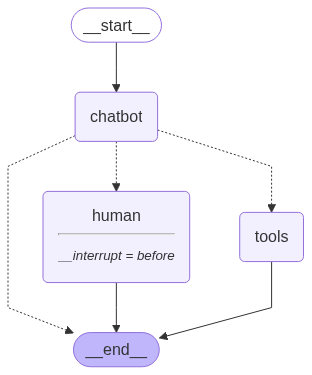

In [69]:
from IPython.display import Image, display

try:
    display(Image(human_loop_chatbot.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

### Step 4: Test Human-in-the-Loop

Let's test the interrupt functionality:


In [ ]:
def test_human_loop():
    print("🤝 Testing Human-in-the-Loop")
    print("=" * 50)
    
    config = {"configurable": {"thread_id": "human_loop_test"}}
    
    # Request that requires human help
    print("📝 Asking agent to request human help:")
    
    initial_result = human_loop_chatbot.invoke(
        {"messages": [HumanMessage(content="I need help with a complex decision. Can you request human assistance?")]},
        config
    )
    
    for message in initial_result["messages"]:
        if isinstance(message, HumanMessage):
            print(f"👤 Human: {message.content}")
        elif isinstance(message, AIMessage):
            if hasattr(message, 'tool_calls') and message.tool_calls:
                print(f"🤖 AI: [Requesting human help]")
            else:
                print(f"🤖 AI: {message.content}")
    
    # Check if execution was interrupted
    state = human_loop_chatbot.get_state(config)
    print(f"\n🔍 Current state:")
    print(f"Next node to execute: {state.next}")
    print(f"Ask human flag: {state.values.get('ask_human', False)}")
    
    if state.next == ("human",):
        print("\n✅ Execution interrupted! Human intervention required.")
        print("In a real app, a human would now review and provide input.")
        
        # Continue execution (simulating human approval)
        print("\n▶️ Continuing execution (simulating human input)...")
        final_result = human_loop_chatbot.invoke(None, config)
        
        # Show the final messages
        new_messages = final_result["messages"][len(initial_result["messages"]):]
        for message in new_messages:
            if isinstance(message, ToolMessage):
                print(f"👨‍💼 Human: {message.content}")
            elif isinstance(message, AIMessage):
                print(f"🤖 AI: {message.content}")
    
    return final_result

# Test the human-in-the-loop functionality
human_loop_result = test_human_loop()


🤝 Testing Human-in-the-Loop
📝 Asking agent to request human help:
👤 Human: I need help with a complex decision. Can you request human assistance?
🤖 AI: [Requesting human help]

🔍 Current state:
Next node to execute: ('human',)
Ask human flag: True

✅ Execution interrupted! Human intervention required.
In a real app, a human would now review and provide input.

▶️ Continuing execution (simulating human input)...
👨‍💼 Human: 👨‍🏫 Human: I've reviewed your request. Please proceed with the computation and provide a step-by-step explanation.
🤖 AI: I have requested human assistance for your complex decision. Now, I will assist you with the computation. What specific calculations or decisions do you need help with?


## 🎯 Part 6: Advanced State Management {#part6}

So far, we've used simple state with just messages. But LangGraph can handle much more complex state for sophisticated applications.

### Custom State Example: Research Assistant

Let's build a research assistant that:
- Tracks research topics
- Maintains a list of findings
- Counts the number of searches performed
- Has a confidence score for its conclusions


In [ ]:
# Advanced State for Research Assistant
class ResearchState(TypedDict):
    messages: Annotated[list, add_messages]
    research_topic: str
    findings: List[str]
    search_count: int
    confidence_score: float
    max_searches: int

# Research tools
@tool
def web_search(query: str) -> str:
    """
    Simulate a web search (in real app, use actual search API).
    
    Args:
        query: Search query
        
    Returns:
        Search results
    """
    # Simulate search results
    results = {
        "python": "Python is a high-level programming language known for its simplicity and versatility.",
        "machine learning": "Machine learning is a subset of AI that enables computers to learn from data.",
        "langgraph": "LangGraph is a library for building stateful, multi-actor applications with LLMs.",
        "default": f"Search results for '{query}': This is simulated search data with relevant information."
    }
    
    return results.get(query.lower(), results["default"])

@tool
def analyze_findings(findings_list: str) -> str:
    """
    Analyze research findings and provide insights.
    
    Args:
        findings_list: Comma-separated list of findings
        
    Returns:
        Analysis of the findings
    """
    findings = findings_list.split(',')
    analysis = f"Analysis of {len(findings)} findings: "
    
    if len(findings) >= 3:
        analysis += "Comprehensive research completed. Strong evidence base."
    elif len(findings) >= 2:
        analysis += "Good research foundation. Consider additional sources."
    else:
        analysis += "Limited research. More investigation needed."
    
    return analysis

# Research tools list
research_tools = [web_search, analyze_findings, calculator, get_current_time]
research_llm = llm.bind_tools(research_tools)

print("✅ Advanced research assistant tools created!")
print("Tools available: web_search, analyze_findings, calculator, get_current_time")


✅ Advanced research assistant tools created!
Tools available: web_search, analyze_findings, calculator, get_current_time


### Create Research Assistant Nodes


In [ ]:
def research_chatbot(state: ResearchState) -> Dict[str, Any]:
    """Research chatbot with advanced state management"""
    messages = state["messages"]
    
    # Add context about current research state
    context_message = f"""
Current research status:
- Topic: {state.get('research_topic', 'Not set')}
- Findings so far: {len(state.get('findings', []))}
- Searches performed: {state.get('search_count', 0)}/{state.get('max_searches', 5)}
- Confidence: {state.get('confidence_score', 0.0):.1f}/10.0
"""
    
    # Add context to messages for the LLM
    full_messages = messages + [HumanMessage(content=context_message)]
    response = research_llm.invoke(full_messages)
    
    return {"messages": [response]}

def research_tool_node(state: ResearchState) -> Dict[str, Any]:
    """Enhanced tool node that updates research state"""
    # Execute tools
    tool_node_result = ToolNode(research_tools)(state)
    
    # Update research-specific state
    updates = {}
    last_message = state["messages"][-1]
    
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        for tool_call in last_message.tool_calls:
            if tool_call['name'] == 'web_search':
                # Increment search count
                updates["search_count"] = state.get("search_count", 0) + 1
                
                # Add to findings
                current_findings = state.get("findings", [])
                query = tool_call['args']['query']
                current_findings.append(f"Search: {query}")
                updates["findings"] = current_findings
                
                # Update confidence based on number of searches
                search_count = updates["search_count"]
                updates["confidence_score"] = min(search_count * 2.0, 10.0)
    
    # Combine tool results with state updates
    result = {"messages": tool_node_result["messages"]}
    result.update(updates)
    
    return result

def initialize_research(state: ResearchState) -> Dict[str, Any]:
    """Initialize research session if needed"""
    updates = {}
    
    if not state.get("research_topic"):
        # Extract topic from the first message
        if state["messages"]:
            first_msg = state["messages"][0].content
            updates["research_topic"] = first_msg[:100]  # First 100 chars as topic
    
    if "search_count" not in state:
        updates["search_count"] = 0
    
    if "findings" not in state:
        updates["findings"] = []
        
    if "confidence_score" not in state:
        updates["confidence_score"] = 0.0
        
    if "max_searches" not in state:
        updates["max_searches"] = 5
    
    return updates

print("✅ Research assistant nodes created!")
print("- research_chatbot: Handles conversations with research context")
print("- research_tool_node: Executes tools and updates research state") 
print("- initialize_research: Sets up initial research parameters")


✅ Research assistant nodes created!
- research_chatbot: Handles conversations with research context
- research_tool_node: Executes tools and updates research state
- initialize_research: Sets up initial research parameters


### Build the Research Assistant Graph


In [ ]:
def research_router(state: ResearchState) -> Literal["tools", "complete", "__end__"]:
    """Advanced routing logic for research assistant"""
    
    # Check if we've reached max searches
    if state.get("search_count", 0) >= state.get("max_searches", 5):
        return "complete"
    
    # Check for tool calls
    messages = state["messages"]
    if messages:
        last_message = messages[-1]
        if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
            return "tools"
    
    return "__end__"

def complete_research(state: ResearchState) -> Dict[str, Any]:
    """Finalize research and provide summary"""
    findings = state.get("findings", [])
    confidence = state.get("confidence_score", 0.0)
    topic = state.get("research_topic", "Unknown")
    
    summary = f"""
Research Complete!

Topic: {topic}
Total findings: {len(findings)}
Confidence score: {confidence:.1f}/10.0

Summary of findings:
{chr(10).join(f"- {finding}" for finding in findings)}

Research session concluded.
"""
    
    return {"messages": [AIMessage(content=summary)]}

# Build the research assistant graph
research_builder = StateGraph(ResearchState)

# Add nodes
research_builder.add_node("initialize", initialize_research)
research_builder.add_node("chatbot", research_chatbot)
research_builder.add_node("tools", research_tool_node)
research_builder.add_node("complete", complete_research)

# Add edges
research_builder.add_edge(START, "initialize")
research_builder.add_edge("initialize", "chatbot")

# Add conditional routing
research_builder.add_conditional_edges(
    "chatbot",
    research_router,
    {
        "tools": "tools",
        "complete": "complete",
        "__end__": END
    }
)

research_builder.add_edge("tools", "chatbot")
research_builder.add_edge("complete", END)

# Compile
research_assistant = research_builder.compile(checkpointer=memory)

print("✅ Advanced research assistant created!")
print("Flow: START → initialize → chatbot → [tools/complete/end] → ...")


✅ Advanced research assistant created!
Flow: START → initialize → chatbot → [tools/complete/end] → ...


### Test the Advanced Research Assistant


In [ ]:
def test_research_assistant():
    print("🔬 Testing Advanced Research Assistant")
    print("=" * 50)
    
    config = {"configurable": {"thread_id": "research_session_1"}}
    
    # Start research
    result = research_assistant.invoke(
        {"messages": [HumanMessage(content="I want to research machine learning applications")]},
        config
    )
    
    print("📊 Research Session Started")
    print("-" * 30)
    
    # Show state after initialization
    state = research_assistant.get_state(config)
    print(f"Topic: {state.values.get('research_topic', 'Not set')}")
    print(f"Search count: {state.values.get('search_count', 0)}")
    print(f"Confidence: {state.values.get('confidence_score', 0.0):.1f}")
    print(f"Findings: {len(state.values.get('findings', []))}")
    
    # Continue with searches
    print("\n📝 Requesting searches...")
    result = research_assistant.invoke(
        {"messages": [HumanMessage(content="Please search for information about machine learning")]},
        config
    )
    
    # Show updated state
    state = research_assistant.get_state(config)
    print(f"\nAfter search:")
    print(f"Search count: {state.values.get('search_count', 0)}")
    print(f"Confidence: {state.values.get('confidence_score', 0.0):.1f}")
    print(f"Findings: {state.values.get('findings', [])}")
    
    # Show final messages
    print("\n💬 Final Response:")
    for message in result["messages"][-2:]:  # Show last 2 messages
        if isinstance(message, HumanMessage):
            print(f"👤 Human: {message.content}")
        elif isinstance(message, AIMessage):
            print(f"🤖 AI: {message.content[:200]}...")  # Truncate for readability
        elif isinstance(message, ToolMessage):
            print(f"🔧 Tool: {message.content[:100]}...")
    
    return result

# Test the research assistant
research_result = test_research_assistant()


🔬 Testing Advanced Research Assistant


BadRequestError: Error code: 400 - {'error': {'message': "An assistant message with 'tool_calls' must be followed by tool messages responding to each 'tool_call_id'. The following tool_call_ids did not have response messages: call_ncSr0FhW02n2pRt3nmYgG1mP", 'type': 'invalid_request_error', 'param': 'messages.[2].role', 'code': None}}

## 👥 Part 7: Multi-Agent Systems {#part7}

LangGraph really shines when building systems with multiple specialized agents working together. Let's create a simple multi-agent system with:

1. **Researcher Agent**: Gathers information
2. **Analyst Agent**: Analyzes the information
3. **Writer Agent**: Creates final reports

### Multi-Agent State


In [ ]:
class MultiAgentState(TypedDict):
    messages: Annotated[list, add_messages]
    task: str
    research_data: List[str]
    analysis_results: List[str]
    final_report: str
    current_agent: str
    task_complete: bool

# Specialized agents
def researcher_agent(state: MultiAgentState) -> Dict[str, Any]:
    """Specialized research agent"""
    
    # Create research-focused prompt
    research_prompt = f"""
You are a Research Agent. Your job is to gather information about: {state.get('task', 'the given topic')}.

Current research data: {state.get('research_data', [])}

Please search for relevant information and add your findings to the research data.
Focus on factual information and reliable sources.
"""
    
    messages = state["messages"] + [HumanMessage(content=research_prompt)]
    response = research_llm.invoke(messages)
    
    return {
        "messages": [response],
        "current_agent": "researcher"
    }

def analyst_agent(state: MultiAgentState) -> Dict[str, Any]:
    """Specialized analysis agent"""
    
    research_data = state.get('research_data', [])
    analysis_prompt = f"""
You are an Analysis Agent. Your job is to analyze the research data and provide insights.

Research data to analyze:
{chr(10).join(f"- {data}" for data in research_data)}

Please provide analysis, identify patterns, and draw conclusions.
Focus on insights and implications.
"""
    
    messages = state["messages"] + [HumanMessage(content=analysis_prompt)]
    response = llm.invoke(messages)
    
    # Extract analysis from response (simplified)
    analysis_results = state.get('analysis_results', [])
    analysis_results.append(f"Analysis: {response.content[:200]}...")
    
    return {
        "messages": [response],
        "analysis_results": analysis_results,
        "current_agent": "analyst"
    }

def writer_agent(state: MultiAgentState) -> Dict[str, Any]:
    """Specialized writing agent"""
    
    research_data = state.get('research_data', [])
    analysis_results = state.get('analysis_results', [])
    
    writing_prompt = f"""
You are a Writing Agent. Create a comprehensive final report.

Research Data:
{chr(10).join(f"- {data}" for data in research_data)}

Analysis Results:
{chr(10).join(f"- {result}" for result in analysis_results)}

Please create a well-structured final report that combines the research and analysis.
"""
    
    messages = state["messages"] + [HumanMessage(content=writing_prompt)]
    response = llm.invoke(messages)
    
    return {
        "messages": [response],
        "final_report": response.content,
        "current_agent": "writer",
        "task_complete": True
    }

print("✅ Multi-agent system agents created!")
print("- Researcher Agent: Gathers information")
print("- Analyst Agent: Analyzes findings") 
print("- Writer Agent: Creates final reports")


### Build Multi-Agent Workflow


In [ ]:
def multi_agent_router(state: MultiAgentState) -> Literal["researcher", "analyst", "writer", "__end__"]:
    """Route between different agents based on current state"""
    
    if state.get("task_complete", False):
        return "__end__"
    
    current_agent = state.get("current_agent", "")
    research_data = state.get("research_data", [])
    analysis_results = state.get("analysis_results", [])
    
    # Start with researcher
    if not current_agent:
        return "researcher"
    
    # After researcher, go to analyst if we have research data
    if current_agent == "researcher" and len(research_data) > 0:
        return "analyst"
    
    # After analyst, go to writer if we have analysis
    if current_agent == "analyst" and len(analysis_results) > 0:
        return "writer"
    
    # Continue with current agent if more work needed
    if current_agent == "researcher" and len(research_data) < 2:
        return "researcher"
    
    return "__end__"

def initialize_multi_agent(state: MultiAgentState) -> Dict[str, Any]:
    """Initialize multi-agent state"""
    updates = {}
    
    if not state.get("task") and state.get("messages"):
        # Extract task from first message
        first_msg = state["messages"][0].content
        updates["task"] = first_msg
    
    if "research_data" not in state:
        updates["research_data"] = []
    
    if "analysis_results" not in state:
        updates["analysis_results"] = []
    
    if "current_agent" not in state:
        updates["current_agent"] = ""
    
    if "task_complete" not in state:
        updates["task_complete"] = False
    
    return updates

# Enhanced tool node for multi-agent
def multi_agent_tool_node(state: MultiAgentState) -> Dict[str, Any]:
    """Tool node that updates research data"""
    tool_result = ToolNode(research_tools)(state)
    
    # Update research data if web search was performed
    updates = {}
    last_message = state["messages"][-1]
    
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        for tool_call in last_message.tool_calls:
            if tool_call['name'] == 'web_search':
                research_data = state.get("research_data", [])
                query = tool_call['args']['query']
                # Add the search result to research data
                research_data.append(f"Search result for '{query}': {tool_result['messages'][-1].content}")
                updates["research_data"] = research_data
    
    result = {"messages": tool_result["messages"]}
    result.update(updates)
    return result

# Build multi-agent graph
multi_agent_builder = StateGraph(MultiAgentState)

# Add nodes
multi_agent_builder.add_node("initialize", initialize_multi_agent)
multi_agent_builder.add_node("researcher", researcher_agent)
multi_agent_builder.add_node("tools", multi_agent_tool_node)
multi_agent_builder.add_node("analyst", analyst_agent)
multi_agent_builder.add_node("writer", writer_agent)

# Add edges
multi_agent_builder.add_edge(START, "initialize")

# From initialize, route to appropriate agent
multi_agent_builder.add_conditional_edges(
    "initialize",
    multi_agent_router,
    {
        "researcher": "researcher",
        "analyst": "analyst",
        "writer": "writer",
        "__end__": END
    }
)

# Researcher can use tools or continue to next agent
multi_agent_builder.add_conditional_edges(
    "researcher",
    lambda state: "tools" if (
        state["messages"] and 
        hasattr(state["messages"][-1], 'tool_calls') and 
        state["messages"][-1].tool_calls
    ) else multi_agent_router(state),
    {
        "tools": "tools",
        "researcher": "researcher",
        "analyst": "analyst",
        "writer": "writer",
        "__end__": END
    }
)

# After tools, route to next agent
multi_agent_builder.add_conditional_edges(
    "tools",
    multi_agent_router,
    {
        "researcher": "researcher",
        "analyst": "analyst",
        "writer": "writer",
        "__end__": END
    }
)

# Analyst routes to next agent
multi_agent_builder.add_conditional_edges(
    "analyst",
    multi_agent_router,
    {
        "researcher": "researcher",
        "analyst": "analyst",
        "writer": "writer",
        "__end__": END
    }
)

# Writer completes the task
multi_agent_builder.add_edge("writer", END)

# Compile
multi_agent_system = multi_agent_builder.compile(checkpointer=checkpointer)

print("✅ Multi-agent system created!")
print("Flow: initialize → researcher → [tools] → analyst → writer → END")


### Test Multi-Agent System


In [ ]:
def test_multi_agent_system():
    print("👥 Testing Multi-Agent System")
    print("=" * 50)
    
    config = {"configurable": {"thread_id": "multi_agent_test"}}
    
    # Start the multi-agent workflow
    result = multi_agent_system.invoke(
        {"messages": [HumanMessage(content="Research and analyze the benefits of renewable energy")]},
        config
    )
    
    # Get final state
    final_state = multi_agent_system.get_state(config)
    
    print("📊 Multi-Agent Workflow Complete!")
    print("-" * 40)
    print(f"Task: {final_state.values.get('task', 'Not set')}")
    print(f"Current Agent: {final_state.values.get('current_agent', 'None')}")
    print(f"Task Complete: {final_state.values.get('task_complete', False)}")
    
    print(f"\n🔬 Research Data ({len(final_state.values.get('research_data', []))}):")
    for i, data in enumerate(final_state.values.get('research_data', []), 1):
        print(f"{i}. {data[:100]}...")
    
    print(f"\n📈 Analysis Results ({len(final_state.values.get('analysis_results', []))}):")
    for i, analysis in enumerate(final_state.values.get('analysis_results', []), 1):
        print(f"{i}. {analysis[:100]}...")
    
    print(f"\n📝 Final Report:")
    final_report = final_state.values.get('final_report', 'No report generated')
    print(final_report[:300] + "..." if len(final_report) > 300 else final_report)
    
    print(f"\n💬 Total Messages: {len(final_state.values.get('messages', []))}")
    
    return result

# Test the multi-agent system
multi_agent_result = test_multi_agent_system()


## 🌟 Part 8: Real-World Use Cases {#part8}

Now that you understand LangGraph fundamentals, let's explore some real-world applications:

### 🎯 Use Case Examples

1. **Customer Support Agent**
   - Handles inquiries with memory
   - Escalates to humans when needed
   - Accesses knowledge bases and APIs

2. **Code Review Assistant**  
   - Analyzes code for issues
   - Suggests improvements
   - Runs tests and checks

3. **Content Creation Pipeline**
   - Research → Outline → Write → Edit → Publish
   - Multiple specialized agents
   - Human approval at key stages

4. **Data Analysis Workflow**
   - Data ingestion → Cleaning → Analysis → Visualization → Report

### 💡 Key Patterns You've Learned

1. **State Management**: Custom state for complex workflows
2. **Tool Integration**: External APIs and functions
3. **Human-in-the-Loop**: Interrupts and approvals
4. **Multi-Agent Coordination**: Specialized agents working together
5. **Conditional Routing**: Dynamic decision making
6. **Memory & Persistence**: Conversation continuity

### 🚀 Next Steps

To build production applications:

1. **Error Handling**: Add try-catch blocks and error recovery
2. **Authentication**: Secure your APIs and data
3. **Monitoring**: Use LangSmith for observability
4. **Scaling**: Consider deployment options
5. **Testing**: Write comprehensive tests
6. **Documentation**: Document your workflows


## 🎓 Conclusion & Summary

Congratulations! 🎉 You've completed the comprehensive LangGraph tutorial. Here's what you've accomplished:

### ✅ What You've Built

1. **Simple Chatbot** - Basic conversation with LLM
2. **Memory-Enabled Agent** - Persistent conversations with checkpointing  
3. **Tool-Integrated Agent** - External API calls and function execution
4. **Human-in-the-Loop System** - Interrupts and human oversight
5. **Advanced State Management** - Complex workflows with custom state
6. **Multi-Agent System** - Coordinated specialized agents

### 🧠 Core Concepts Mastered

- **State**: The memory and data of your application
- **Nodes**: Functions that process and transform state
- **Edges**: Connections that define workflow flow
- **Conditional Routing**: Dynamic decision making
- **Checkpointing**: Persistent memory across sessions
- **Interrupts**: Human-in-the-loop capabilities
- **Tools**: External function integration

### 📚 Additional Resources

- **Official Documentation**: https://langchain-ai.github.io/langgraph/
- **LangSmith Observability**: https://langsmith.langchain.com/
- **LangChain Community**: https://github.com/langchain-ai/langchain
- **Examples Repository**: https://github.com/langchain-ai/langgraph/tree/main/examples

### 🚀 Your Next Journey

You now have the foundation to build sophisticated AI agents and workflows. Start with a simple use case and gradually add complexity as you become more comfortable with the patterns.

**Happy building with LangGraph!** 🌟

---

*This tutorial was created based on the official LangGraph documentation and best practices. For the latest updates and features, always refer to the official documentation.*


# 🚀 Complete LangGraph Tutorial: From Basics to Advanced Applications

## 📖 Comprehensive Guide for Building Stateful AI Agents

Welcome to the most comprehensive LangGraph tutorial! This notebook will take you from complete beginner to building sophisticated AI agents step by step.

### 🎯 What You'll Learn

By the end of this tutorial, you will:
- ✅ Understand LangGraph's core concepts (Nodes, Edges, State)
- ✅ Build your first simple chatbot
- ✅ Add memory and persistence to conversations
- ✅ Implement tool calling and external integrations
- ✅ Create human-in-the-loop workflows
- ✅ Build multi-agent systems
- ✅ Handle complex state management
- ✅ Deploy production-ready applications

### 📚 Based on Official LangGraph Documentation

This tutorial follows the [official LangGraph documentation](https://langchain-ai.github.io/langgraph/) and incorporates best practices from the LangGraph team.

---

## 📋 Table of Contents

1. **[Setup & Installation](#setup)**
2. **[Part 1: Understanding LangGraph Fundamentals](#part1)**
3. **[Part 2: Building Your First Simple Agent](#part2)**
4. **[Part 3: Adding Memory with Checkpointing](#part3)**
5. **[Part 4: Tool Integration & External APIs](#part4)**
6. **[Part 5: Human-in-the-Loop Workflows](#part5)**
7. **[Part 6: Advanced State Management](#part6)**
8. **[Part 7: Multi-Agent Systems](#part7)**
9. **[Part 8: Real-World Use Cases](#part8)**
10. **[Part 9: Production Deployment](#part9)**

Let's begin this exciting journey! 🌟
